In [141]:
import pandas.io
import warnings
warnings.filterwarnings("ignore")

In [164]:
import numpy as np
#import modin.pandas as pd
import pandas as pd
import seaborn as sns
from pylab import rcParams
sns.set(style="white")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import tree, pipeline, preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import sklearn.pipeline
import joblib

# Functions to read data, slice it into X and y datasets

In [90]:
def readCsvToDataFrame(path, row_with_column_names):
    theDataFrame= pandas.read_csv(path, header=row_with_column_names)
    return theDataFrame

def show_df_info(dataframe):
    # get the data type
    print(type(dataframe))
    print("amount of entries is %s" % dataframe.size)
    print("dimensions= %i" % dataframe.ndim)
    print("shape is ", end="")
    print(dataframe.shape)
    print("axes: ", end="")
    print(dataframe.axes)
    print("data types of columns:")
    print(dataframe.dtypes)
    print("features: %s" % dataframe.columns)

# Phase 1: Load Dataset


In [92]:
PIPELINEPATH= "/Users/admin/Documents/data-labs/module-3/unsupervised-learning-project/your-code/ser_pipeline.pickle"
DATASETPATH = '/Users/admin/Documents/data-labs/module-3/unsupervised-learning-project/your-code/data.csv'
data = readCsvToDataFrame(DATASETPATH, row_with_column_names = 0)


In [93]:
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [94]:
show_df_info(data)


<class 'pandas.core.frame.DataFrame'>
amount of entries is 18777
dimensions= 2
shape is (569, 33)
axes: [RangeIndex(start=0, stop=569, step=1), Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')]
data types of columns:
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             

### Distribution of labels Diagnosis "Malignous" and "Benign"

Text(0.5, 1.0, 'Counts of each Diagnosis level')

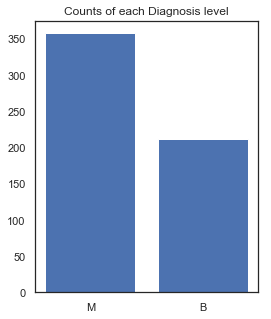

In [95]:
rcParams['figure.figsize'] = 4, 5

plt.bar(data.diagnosis.unique(), data.diagnosis.value_counts())
plt.title('Counts of each Diagnosis level')

# Cleaning the data

In [96]:
data.shape

(569, 33)

In [97]:
data.drop(columns=['Unnamed: 32'], inplace=True)

In [98]:
data.drop(columns=['id'], inplace=True)

In [99]:
data.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

# Exploring the data

### Multicollinearity

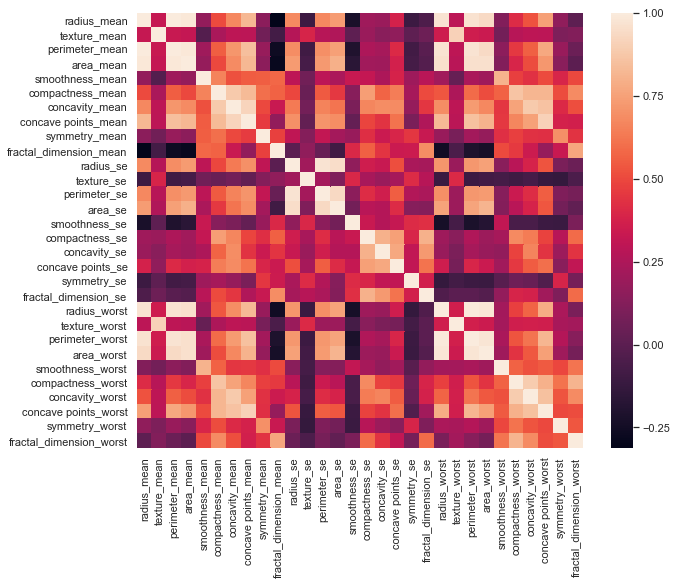

In [100]:
rcParams['figure.figsize'] = 10, 8
corr = data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [101]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop

['perimeter_mean',
 'area_mean',
 'concave points_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

### Dropping columns too correlated

In [102]:
data.drop(columns=to_drop, inplace=True)

In [103]:
data.shape

(569, 21)

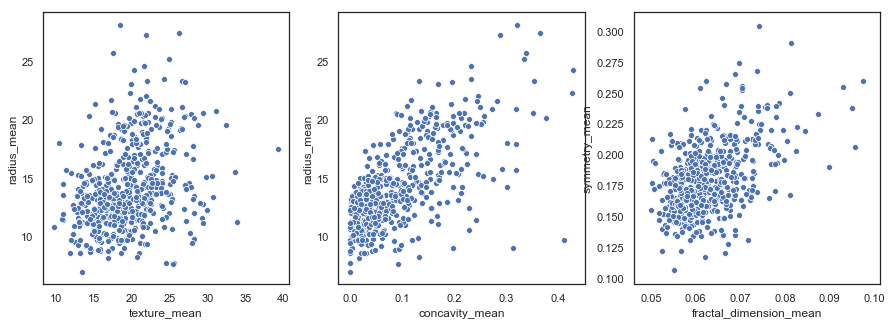

In [104]:
plt.figure(figsize=(15,5))

plt.subplot(131)
sns.scatterplot(data['texture_mean'], data['radius_mean'])
plt.subplot(132)
sns.scatterplot(data['concavity_mean'], data['radius_mean'])
plt.subplot(133)
sns.scatterplot(data['fractal_dimension_mean'], data['symmetry_mean'])


# PCA

In [105]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data[[col for col in data if col != 'diagnosis']])
pca_X = pca.transform(data[[col for col in data if col != 'diagnosis']])


Plotting PCA 1st and 2nd component

[Text(0, 0.5, 'PCA 2'), Text(0.5, 0, 'PCA 1')]

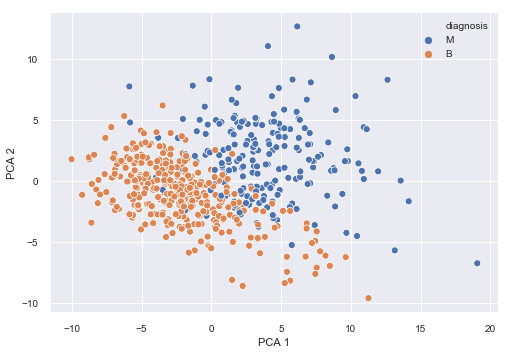

In [186]:
X = data[[col for col in data if col != 'diagnosis']]
ax = sns.scatterplot(pca_X[:,0], pca_X[:,1], hue = data['diagnosis'], legend = 'full')
ax.set(xlabel='PCA 1', ylabel='PCA 2')

# Phase 2: Slice the Dataset into Train, test

In [158]:
def sliceDataFrame(df):

    return df.iloc[:, 1:], df.iloc[:, 0]

In [159]:
## PHASE 2: SLICE DATASET
training_instances, class_labels= sliceDataFrame(data)

In [160]:
class_labels.head()

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_instances, class_labels, train_size=0.8, test_size=0.2)

In [111]:
show_df_info(X_train)

<class 'pandas.core.frame.DataFrame'>
amount of entries is 9100
dimensions= 2
shape is (455, 20)
axes: [Int64Index([359, 289, 309, 322, 215, 202, 541, 121, 308,  33,
            ...
              5, 466, 390, 326, 483, 261, 283, 237, 447, 524],
           dtype='int64', length=455), Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')]
data types of columns:
radius_mean                float64
texture_mean               float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_s

In [112]:
# preview the data
print(X_train.head())
print()
print(y_train.head())

     radius_mean  texture_mean  smoothness_mean  compactness_mean  \
359        9.436         18.32          0.10090           0.05956   
289       11.370         18.89          0.08713           0.05008   
309       13.050         13.84          0.08352           0.03735   
322       12.860         13.32          0.11340           0.08834   
215       13.860         16.93          0.10260           0.15170   

     concavity_mean  symmetry_mean  fractal_dimension_mean  radius_se  \
359        0.027100         0.1506                 0.06959     0.5079   
289        0.023990         0.2013                 0.05955     0.2656   
309        0.004559         0.1453                 0.05518     0.3975   
322        0.038000         0.1543                 0.06476     0.2212   
215        0.099010         0.2106                 0.06916     0.2563   

     texture_se  smoothness_se  compactness_se  concavity_se  \
359      1.2470       0.006836        0.008982      0.023480   
289      1.9740   

# Selecting best model

In [142]:
model_accuracies = pd.DataFrame()

model_accuracies = pd.DataFrame(columns = ['model', 'F1 score', 'precision', 'recall', 'accuracy'])


In [143]:
# Random Forest

cv_score = cross_val_score(RandomForestClassifier(), X_train, y_train, cv = 10, scoring='f1_weighted')
prec = cross_val_score(RandomForestClassifier(), X_train, y_train, cv = 10, scoring='precision_weighted')
rec = cross_val_score(RandomForestClassifier(), X_train, y_train, cv = 10, scoring='recall_weighted')
acc = cross_val_score(RandomForestClassifier(), X_train, y_train, cv = 10, scoring='accuracy')

model_accuracies = model_accuracies.append({'model': 'Random Forest', 
                                            #'accuracy': accuracy_score(y_test, y_pred_test_rf),
                                            'F1 score': np.mean(cv_score),
                                            'precision':np.mean(prec),
                                            'recall': np.mean(rec),
                                            'accuracy': np.mean(acc)},ignore_index=True)
                                         

In [144]:
# Decision Tree

cv_score = cross_val_score(tree.DecisionTreeClassifier(), X_train, y_train, cv = 10, scoring='f1_weighted')
prec = cross_val_score(tree.DecisionTreeClassifier(), X_train, y_train, cv = 10, scoring='precision_weighted')
rec = cross_val_score(tree.DecisionTreeClassifier(), X_train, y_train, cv = 10, scoring='recall_weighted')
acc = cross_val_score(tree.DecisionTreeClassifier(), X_train, y_train, cv = 10, scoring='accuracy')


model_accuracies = model_accuracies.append({'model': 'Decision_Tree', 
                                            #'accuracy': accuracy_score(y_test, y_pred_test_rf),
                                            'F1 score': np.mean(cv_score),
                                            'precision':np.mean(prec),
                                            'recall': np.mean(rec),
                                            'accuracy': np.mean(acc)},ignore_index=True)
                                         

In [149]:
# Gradient Boosting

cv_score = cross_val_score(GradientBoostingClassifier(), X_train, y_train, cv = 10, scoring='f1_weighted')
prec = cross_val_score(GradientBoostingClassifier(), X_train, y_train, cv = 10, scoring='precision_weighted')
rec = cross_val_score(GradientBoostingClassifier(), X_train, y_train, cv = 10, scoring='recall_weighted')
acc = cross_val_score(GradientBoostingClassifier(), X_train, y_train, cv = 10, scoring='accuracy')

model_accuracies = model_accuracies.append({'model': "GradientBoosting", 
                                            'F1 score': np.mean(cv_score),
                                            'precision':np.mean(prec),
                                            'recall': np.mean(rec),
                                            'accuracy': np.mean(acc)},ignore_index=True)

In [152]:
# SVM RBF

from sklearn.svm import SVC

cv_score = cross_val_score(SVC(), X_train, y_train, cv = 10, scoring='f1_weighted')
prec = cross_val_score(SVC(), X_train, y_train, cv = 10, scoring='precision_weighted')
rec = cross_val_score(SVC(), X_train, y_train, cv = 10, scoring='recall_weighted')
acc = cross_val_score(SVC(), X_train, y_train, cv = 10, scoring='accuracy')

model_accuracies = model_accuracies.append({'model': "RBF SVM", 
                                            'F1 score': np.mean(cv_score),
                                            'precision':np.mean(prec),
                                            'recall': np.mean(rec),
                                            'accuracy': np.mean(acc)},ignore_index=True)

In [153]:
# XGBoost

from xgboost import XGBClassifier

cv_score = cross_val_score(XGBClassifier(), X_train, y_train, cv = 10, scoring='f1_weighted')
prec = cross_val_score(XGBClassifier(), X_train, y_train, cv = 10, scoring='precision_weighted')
rec = cross_val_score(XGBClassifier(), X_train, y_train, cv = 10, scoring='recall_weighted')
acc = cross_val_score(XGBClassifier(), X_train, y_train, cv = 10, scoring='accuracy')

model_accuracies = model_accuracies.append({'model': "XGBoost", 
                                            'F1 score': np.mean(cv_score),
                                            'precision':np.mean(prec),
                                            'recall': np.mean(rec),
                                            'accuracy': np.mean(acc)},ignore_index=True)

In [154]:
model_accuracies.sort_values(by = ['F1 score'], ascending=False, inplace=True)
model_accuracies

model  F1 score  precision    recall  accuracy
4           XGBoost  0.953986   0.956471  0.953959  0.953959
2  GradientBoosting  0.949440   0.949373  0.947341  0.947341
0     Random Forest  0.944727   0.939688  0.942993  0.940819
3           RBF SVM  0.914857   0.922107  0.916614  0.916614
1     Decision_Tree  0.909918   0.924650  0.911972  0.907624

In [ ]:
model_accuracies.to_csv('model_accuracies.csv', index=False)

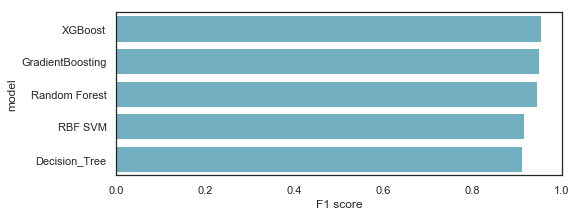

In [157]:
rcParams['figure.figsize'] = 8, 3
    
model_accuracies.sort_values(by = ['F1 score'], ascending=False, inplace=True)

ax = sns.barplot(x = 'F1 score', y = 'model', data = model_accuracies,ci=None, color="c")
#plt.xticks(rotation=45)

## Best model is XGBoost

# Finetuning hyperparameters with GridSearchCV

In [181]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': list(range(50,141, 10)), 'max_depth': [3, 5]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score, '\n')

    
    clf = GridSearchCV(XGBClassifier(), tuned_parameters, cv = 10,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:", '\n')

    print(clf.best_params_, '\n')

    print("Grid scores on development set:", '\n')

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params), '\n')
        
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred), '\n')

# Tuning hyper-parameters for f1 

Best parameters set found on development set: 

{'max_depth': 3, 'n_estimators': 60} 

Grid scores on development set: 

0.949 (+/-0.056) for {'max_depth': 3, 'n_estimators': 50} 

0.958 (+/-0.050) for {'max_depth': 3, 'n_estimators': 60} 

0.958 (+/-0.050) for {'max_depth': 3, 'n_estimators': 70} 

0.958 (+/-0.050) for {'max_depth': 3, 'n_estimators': 80} 

0.954 (+/-0.057) for {'max_depth': 3, 'n_estimators': 90} 

0.954 (+/-0.059) for {'max_depth': 3, 'n_estimators': 100} 

0.954 (+/-0.059) for {'max_depth': 3, 'n_estimators': 110} 

0.952 (+/-0.064) for {'max_depth': 3, 'n_estimators': 120} 

0.952 (+/-0.064) for {'max_depth': 3, 'n_estimators': 130} 

0.952 (+/-0.064) for {'max_depth': 3, 'n_estimators': 140} 

0.947 (+/-0.054) for {'max_depth': 5, 'n_estimators': 50} 

0.951 (+/-0.052) for {'max_depth': 5, 'n_estimators': 60} 

0.954 (+/-0.053) for {'max_depth': 5, 'n_estimators': 70} 

0.954 (+/-0.053) for {'max_depth': 5, 'n_estimators': 80} 


# Strongest features in malignous cells prediction

In [133]:
costa_rf = RandomForestClassifier()

costa_rf = costa_rf.fit(X_train, y_train)

feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': costa_rf.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False).head(15)

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


feature  importance
0              radius_mean    0.344536
4           concavity_mean    0.180337
16       compactness_worst    0.153819
17         concavity_worst    0.051605
7                radius_se    0.044571
18          symmetry_worst    0.029653
2          smoothness_mean    0.027662
15        smoothness_worst    0.023170
6   fractal_dimension_mean    0.018874
1             texture_mean    0.017873
10          compactness_se    0.017374
5            symmetry_mean    0.014779
13             symmetry_se    0.014085
14    fractal_dimension_se    0.011669
3         compactness_mean    0.011003

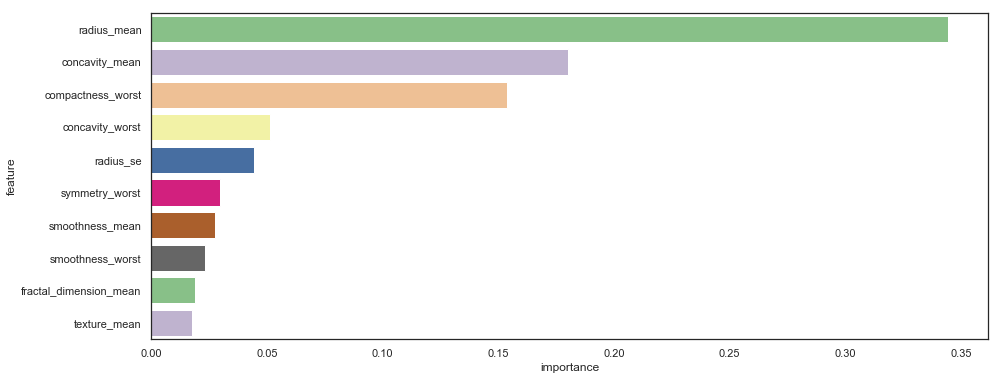

In [139]:

rcParams['figure.figsize'] = 15, 6


feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': costa_rf.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False).head(10)

sns.barplot(x="importance", y="feature", data = feature_importances.sort_values(by='importance', ascending=False).head(10), palette='Accent')
#plt.xticks(rotation=45)


Mean of radius, mean of concavity and worst compactness are the strongest variables in malignous cells prediction

# Phase 3: Create the Pipeline


In [169]:
from sklearn.ensemble import RandomForestClassifier

cart_model= XGBClassifier(params={'max_depth':3, 'n_estimators':60})
pipe= pipeline.Pipeline(steps=[("feature_selection", SelectKBest(chi2, k=8)), ("scale", preprocessing.StandardScaler()),  ("CART", cart_model)])


# Phase 4: Train

In [170]:
# fit all stages of the pipeline

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=8, score_func=<function chi2 at 0x1a23e3f268>)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('CART', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learn...lpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1))])

# Phase 5: EVALUATE

We will evaluate the pipeline using cross-validation and use as quality metric the average of the resulting scores.

In [171]:
# return value is array of scores
scores = cross_val_score(pipe, X_train, y_train, cv=10)
# use as quality metric the average CV score
meanCvAccuracy= scores.mean()
print("Mean CV accuracy= %f" % meanCvAccuracy)

Mean CV accuracy= 0.949611


# Phase 6: SAVE PIPELINE

In [172]:
# the whole pipeline in one single file
joblib.dump(pipe, PIPELINEPATH, compress = 1)

['/Users/admin/Documents/data-labs/module-3/unsupervised-learning-project/your-code/ser_pipeline.pickle']

# Phase 7: LOAD THE PIPELINE

In [173]:
# read the file and deserialize the pipeline
pipeline_loaded = joblib.load(PIPELINEPATH)

# Phase 8: CLASSIFY NEW INSTANCES

In [174]:
display(X_test.head())

radius_mean  texture_mean  smoothness_mean  compactness_mean  \
140        9.738         11.97          0.09250           0.04102   
413       14.990         22.11          0.08515           0.10250   
252       19.730         19.82          0.10620           0.18490   
38        14.990         25.20          0.09387           0.05131   
4         20.290         14.34          0.10030           0.13280   

     concavity_mean  symmetry_mean  fractal_dimension_mean  radius_se  \
140         0.00000         0.1903                 0.06422     0.1988   
413         0.06859         0.1944                 0.05913     0.3186   
252         0.24170         0.1733                 0.06697     0.7661   
38          0.02398         0.1565                 0.05504     1.2140   
4           0.19800         0.1809                 0.05883     0.7572   

     texture_se  smoothness_se  compactness_se  concavity_se  \
140      0.4960       0.006040        0.005656       0.00000   
413      1.3360       0.004449        0.028080       0.03312   
252      0.7800       0.008482        0.050570       0.06800   
38       2.1880       0.006883        0.010940       0.01818   
4        0.7813       0.011490        0.024610       0.05688   

     concave points_se  symmetry_se  fractal_dimension_se  smoothness_worst  \
140            0.00000     0.022770              0.003220           0.12340   
413            0.01196     0.019060              0.004015           0.10770   
252            0.01971     0.014670              0.007259           0.17100   
38             0.01917     0.007882              0.001754           0.09387   
4              0.01885     0.017560              0.005115           0.13740   

     compactness_worst  concavity_worst  symmetry_worst  \
140            0.07204          0.00000          0.3105   
413            0.33450          0.31140          0.3163   
252            0.59550          0.84890          0.2749   
38             0.05131          0.02398          0.1565   
4              0.20500          0.40000          0.2364   

     fractal_dimension_worst  
140                  0.08151  
413                  0.09251  
252                  0.12970  
38                   0.05504  
4                    0.07678

In [177]:
result= pipeline_loaded.predict(X_test)
print("class label are", result)
#print(len(pd.Series(y_test)))
#print(len(pd.Series(result)))


class label are ['B' 'B' 'M' 'B' 'M' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B'
 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'M' 'B'
 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'M' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'B' 'B'
 'M' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'B' 'B'
 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B'
 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M'
 'B' 'M' 'B' 'M' 'M' 'M']


In [178]:
y_test
y_test.index = range(len(y_test.index))
#y_test


In [179]:
def plot_cm(y_true, y_pred, p=0.5):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


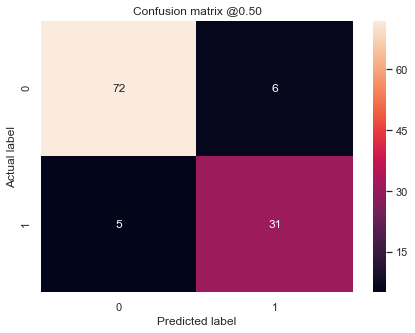

In [180]:
plot_cm(y_test, result)

In [125]:
print('Confusion matrix \n', confusion_matrix(y_test, result), '\n')


Confusion matrix 
 [[73  5]
 [ 5 31]] 



In [182]:
import pandas_profiling

In [183]:
profile = pandas_profiling.ProfileReport(data)
display(profile)